In [240]:
import pandas as pd
import glob
from matplotlib import pyplot as plt

In [241]:
dfs_event_rate = []
dfs_process_time = []
dfs_drop_total_events = []

for folder in glob.glob("*/"):
    fs = glob.glob(f"{folder}/*.csv")
    folder = folder.replace("dt-vol-", "").replace("/", "")
    for f in fs:
        print(f)
        df = pd.read_csv(f)

        if "currDropTotalEvents" in f:
            df.columns = ["time", "current-drop-total-event-rate"]
            # add a column of folder
                # remove "dt-vol" in folder name
            df["folder"] = folder
            dfs_drop_total_events.append(df)

        elif "Process Time" in f:
            df.columns = ["time", "process-time"]
            # the entry is like "1.22 ms", and remove the "ms" and convert to float
            df["process-time"] = df["process-time"].str.replace("ms", "").astype(float)
            title = "process-time"
            df["folder"] = folder
            dfs_process_time.append(df)

        elif "evRate" in f:
            df.columns = ["time", "event-rate"]
            title = "event-rate"
            df["folder"] = folder
            dfs_event_rate.append(df)

dfs_event_rate = pd.concat(dfs_event_rate)
dfs_process_time = pd.concat(dfs_process_time)
dfs_drop_total_events = pd.concat(dfs_drop_total_events)

display(dfs_event_rate)
display(dfs_process_time)
display(dfs_drop_total_events)



dt-vol-1g-1node/evRate-data-2024-06-12 13_43_35.csv
dt-vol-1g-1node/ERSAP Process Time-data-2024-06-12 13_42_06.csv
dt-vol-1g-1node/currDropTotalEvents-data-2024-06-12 13_43_17.csv
dt-vol-2g-2node/ERSAP Process Time-data-2024-06-12 16_35_03.csv
dt-vol-2g-2node/evRate-data-2024-06-12 16_35_27.csv
dt-vol-2g-2node/currDropTotalEvents-data-2024-06-12 16_35_12.csv
dt-vol-2g-2node/evRate-data-2024-06-12 16_35_32.csv
dt-vol-2g-2node/ERSAP Process Time-data-2024-06-12 16_34_55.csv
dt-vol-2g-2node/currDropTotalEvents-data-2024-06-12 16_35_19.csv
dt-vol-5g-2node/evRate-data-2024-06-12 16_40_35.csv
dt-vol-5g-2node/currDropTotalEvents-data-2024-06-12 16_40_22.csv
dt-vol-5g-2node/ERSAP Process Time-data-2024-06-12 16_40_16.csv
dt-vol-5g-2node/currDropTotalEvents-data-2024-06-12 16_40_27.csv
dt-vol-5g-2node/evRate-data-2024-06-12 16_40_40.csv
dt-vol-5g-2node/ERSAP Process Time-data-2024-06-12 16_40_10.csv
dt-vol-10g-1node/currDropTotalEvents-data-2024-06-12 15_40_16.csv
dt-vol-10g-1node/evRate-data-

,time,event-rate,folder
0,2024-06-11 16:02:30,4310,1g-1node
1,2024-06-11 16:02:45,4296,1g-1node
2,2024-06-11 16:03:00,4295,1g-1node
3,2024-06-11 16:03:15,4302,1g-1node
4,2024-06-11 16:03:30,4301,1g-1node
...,...,...,...
39,2024-06-11 17:02:15,8598,2g-1node
40,2024-06-11 17:02:30,8615,2g-1node
41,2024-06-11 17:02:45,8605,2g-1node
42,2024-06-11 17:03:00,8610,2g-1node


,time,process-time,folder
0,2024-06-11 16:02:30,2.00,1g-1node
1,2024-06-11 16:02:45,1.84,1g-1node
2,2024-06-11 16:03:00,1.57,1g-1node
3,2024-06-11 16:03:15,1.82,1g-1node
4,2024-06-11 16:03:30,1.55,1g-1node
...,...,...,...
39,2024-06-11 17:02:15,1.47,2g-1node
40,2024-06-11 17:02:30,1.45,2g-1node
41,2024-06-11 17:02:45,1.51,2g-1node
42,2024-06-11 17:03:00,1.50,2g-1node


,time,current-drop-total-event-rate,folder
0,2024-06-11 16:02:30,0.422,1g-1node
1,2024-06-11 16:02:45,0.444,1g-1node
2,2024-06-11 16:03:00,0.511,1g-1node
3,2024-06-11 16:03:15,0.400,1g-1node
4,2024-06-11 16:03:30,0.378,1g-1node
...,...,...,...
39,2024-06-11 17:02:15,0.489,2g-1node
40,2024-06-11 17:02:30,0.644,2g-1node
41,2024-06-11 17:02:45,0.511,2g-1node
42,2024-06-11 17:03:00,0.556,2g-1node


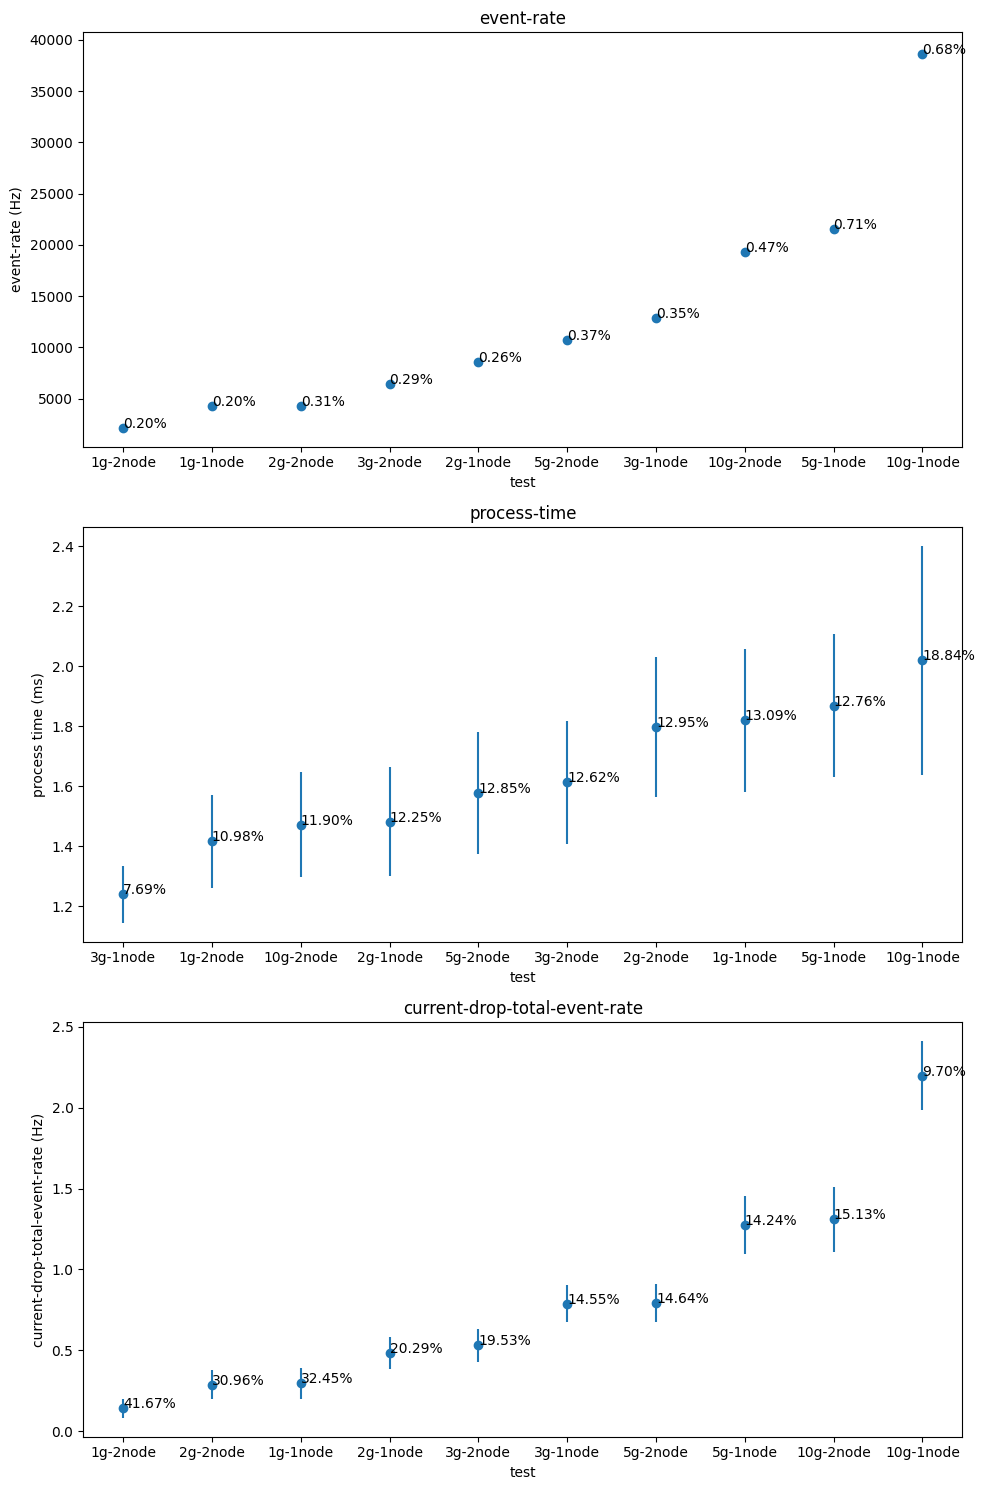

In [243]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

dataframes = [dfs_event_rate, dfs_process_time, dfs_drop_total_events]
for idx, df in enumerate(dataframes):
    # get the mean and std of each folder
    df_mean = df.groupby("folder").mean().sort_values(df.columns[1], ascending=True)
    df_std = df.groupby("folder").std().sort_values(df.columns[1], ascending=True)

    # plot mean and std of each folder in the same plot. The dot is the mean, and the error bar is the std centered at the mean
    axs[idx].errorbar(df_mean.index, df_mean[df.columns[1]], yerr=df_std[df.columns[1]], fmt='o')
    # annotate the percentage of the std
    for i, txt in enumerate(df_std[df.columns[1]]):
        axs[idx].annotate(f"{txt/df_mean[df.columns[1]].iloc[i]:.2%}", (df_mean.index[i], df_mean[df.columns[1]].iloc[i]))
    axs[idx].set_xlabel("test")
    # make xlabel vertical
    # axs[idx].set_xticklabels(df_mean.index, rotation=90)
    # axs[idx].set_ylabel(df.columns[1])
    if "process-time" in df.columns[1]:
        axs[idx].set_ylabel("process time (ms)")
    else:
        axs[idx].set_ylabel(df.columns[1]+" (Hz)")
    axs[idx].set_title(df.columns[1])

plt.tight_layout()
plt.show()